In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de gráficos
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# --- 1. CARGA DE DATOS ---
file_path = 'datos_recolector.csv' 
output_path = 'datos_limpios.csv'

try:
    df = pd.read_csv(file_path)
    print(f"1. Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")
except FileNotFoundError:
    print("Error: No se encuentra el archivo.")
    raise

cols_sensores = [c for c in df.columns if c.startswith('S_')]
cols_acciones = [c for c in df.columns if c.startswith('A_')]

X = df[cols_sensores]
y = df[cols_acciones]

# --- 2. LIMPIEZA AUTOMÁTICA (Columnas Constantes) ---
std_dev = X.std()
cols_constantes = std_dev[std_dev == 0].index.tolist()
if cols_constantes:
    print(f"\n2. Eliminando {len(cols_constantes)} columnas de sensores constantes.")
    X = X.drop(columns=cols_constantes)

# --- 2.5 LIMPIEZA MANUAL (Tu petición) ---
sensores_basura = ['S_damage', 'S_distFromStart', 'S_lastLapTime']
a_borrar_manual = [c for c in sensores_basura if c in X.columns]

if a_borrar_manual:
    print(f"\n2.5 Eliminando sensores manuales: {a_borrar_manual}")
    X = X.drop(columns=a_borrar_manual)

# --- 3. LIMPIEZA AUTOMÁTICA (Columnas Redundantes) ---
UMBRAL_CORRELACION = 0.95 
print(f"\n3. Analizando correlaciones entre columnas (Umbral: {UMBRAL_CORRELACION*100}%)...")

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > UMBRAL_CORRELACION)]

if to_drop:
    print(f"   Eliminando {len(to_drop)} sensores redundantes.")
    X = X.drop(columns=to_drop)
else:
    print("   No se encontraron sensores redundantes.")

# --- 4. UNIFICACIÓN Y LIMPIEZA DE FILAS (NUEVO) ---
print("-" * 60)
print("4. Procesando filas...")

# Unimos todo en el dataframe final
df_final = pd.concat([X, y], axis=1)

# Contamos cuántas hay antes de limpiar
filas_antes = df_final.shape[0]

# --- AQUÍ ELIMINAMOS LAS FILAS DUPLICADAS ---
df_final = df_final.drop_duplicates()

filas_despues = df_final.shape[0]
filas_borradas = filas_antes - filas_despues

if filas_borradas > 0:
    print(f"   [!] Se eliminaron {filas_borradas} FILAS duplicadas.")
else:
    print("   No se encontraron filas duplicadas.")

# --- 5. GUARDAR ---
df_final.to_csv(output_path, index=False)

print("-" * 60)
print(f"¡ÉXITO! Archivo '{output_path}' generado.")
print(f"Dimensiones finales: {df_final.shape[0]} filas x {df_final.shape[1]} columnas")
print("Columnas finales de sensores:")
print(list(X.columns))

1. Datos cargados: 81025 filas, 79 columnas

2. Eliminando 42 columnas de sensores constantes.

2.5 Eliminando sensores manuales: ['S_damage', 'S_distFromStart', 'S_lastLapTime']

3. Analizando correlaciones entre columnas (Umbral: 95.0%)...
   Eliminando 9 sensores redundantes.
------------------------------------------------------------
4. Procesando filas...
   [!] Se eliminaron 82 FILAS duplicadas.
------------------------------------------------------------
¡ÉXITO! Archivo 'datos_limpios.csv' generado.
Dimensiones finales: 80943 filas x 25 columnas
Columnas finales de sensores:
['S_angle', 'S_distRaced', 'S_gear', 'S_rpm', 'S_speed', 'S_track_0', 'S_track_3', 'S_track_4', 'S_track_5', 'S_track_6', 'S_track_7', 'S_track_8', 'S_track_9', 'S_track_10', 'S_track_11', 'S_track_12', 'S_track_13', 'S_track_14', 'S_track_15', 'S_track_16', 'S_trackPos', 'S_z']


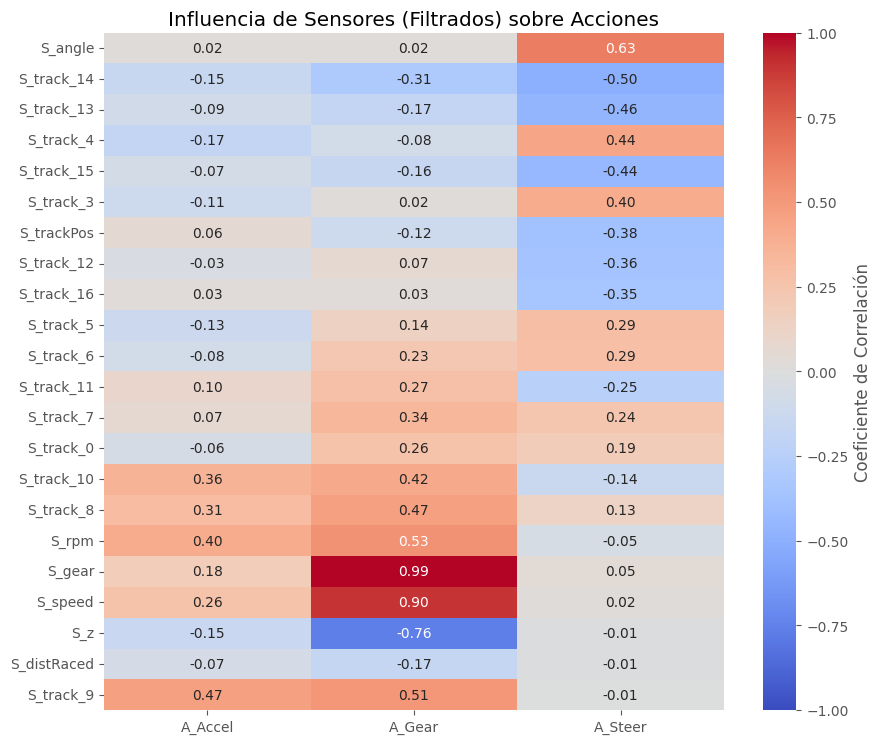

In [2]:
# --- 5. VISUALIZACIÓN FINAL (Solo sensores limpios) ---

# Unimos temporalmente X (sensores limpios) con y (acciones)
df_limpio_viz = pd.concat([X, y], axis=1)

# Calcular matriz de correlación sobre estos datos limpios
correlation_matrix = df_limpio_viz.corr()

# Extraer solo la parte de Sensores (filas) vs Acciones (columnas)
# Usamos X.columns para asegurarnos de que solo salgan los que no borraste
target_corr = correlation_matrix.loc[X.columns, y.columns]

# Ordenar por la magnitud de la correlación con 'A_Steer' para facilitar la lectura
if 'A_Steer' in target_corr.columns:
    target_corr = target_corr.sort_values(by='A_Steer', key=abs, ascending=False)

# Graficar
plt.figure(figsize=(10, len(X.columns) * 0.4)) # Ajuste dinámico de altura según cuántos sensores queden
sns.heatmap(target_corr, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0, 
            vmin=-1, 
            vmax=1,
            cbar_kws={'label': 'Coeficiente de Correlación'})

plt.title('Influencia de Sensores (Filtrados) sobre Acciones')
plt.show()

In [3]:
print("TOP 7 SENSORES MÁS INFLUYENTES (Usando datos limpios X)")
print("=" * 60)

# Iteramos sobre las columnas de acciones (y)
for col_accion in y.columns:
    # 1. CORRECCIÓN AQUÍ: Usamos 'X' (limpio) y 'y' (acciones)
    # X ya no tiene columnas constantes, así que no dará warning de división por cero
    corrs = X.corrwith(y[col_accion])
    
    # 2. Ordenar por importancia (valor absoluto)
    top_sensores = corrs.abs().sort_values(ascending=False).head(7)
    
    print(f"\n[{col_accion.upper()}] está determinado principalmente por:")
    for sensor, val_abs in top_sensores.items():
        val_real = corrs[sensor] # Recuperamos el signo (+ o -)
        signo = "(+)" if val_real > 0 else "(-)"
        
        # Filtramos NaN por seguridad (aunque X ya no debería tenerlos)
        if not np.isnan(val_real):
            print(f"   {signo} {sensor:<20} : {val_real:.4f}")

TOP 7 SENSORES MÁS INFLUYENTES (Usando datos limpios X)

[A_ACCEL] está determinado principalmente por:
   (+) S_track_9            : 0.4684
   (+) S_rpm                : 0.4000
   (+) S_track_10           : 0.3630
   (+) S_track_8            : 0.3097
   (+) S_speed              : 0.2578
   (+) S_gear               : 0.1823
   (-) S_track_4            : -0.1726

[A_GEAR] está determinado principalmente por:
   (+) S_gear               : 0.9941
   (+) S_speed              : 0.9034
   (-) S_z                  : -0.7604
   (+) S_rpm                : 0.5322
   (+) S_track_9            : 0.5093
   (+) S_track_8            : 0.4659
   (+) S_track_10           : 0.4153

[A_STEER] está determinado principalmente por:
   (+) S_angle              : 0.6306
   (-) S_track_14           : -0.5046
   (-) S_track_13           : -0.4625
   (+) S_track_4            : 0.4441
   (-) S_track_15           : -0.4408
   (+) S_track_3            : 0.3990
   (-) S_trackPos           : -0.3801


ANÁLISIS DE IMPORTANCIA BASADO EN ARBOLES (Random Forest)
Detecta relaciones complejas no lineales.
------------------------------------------------------------


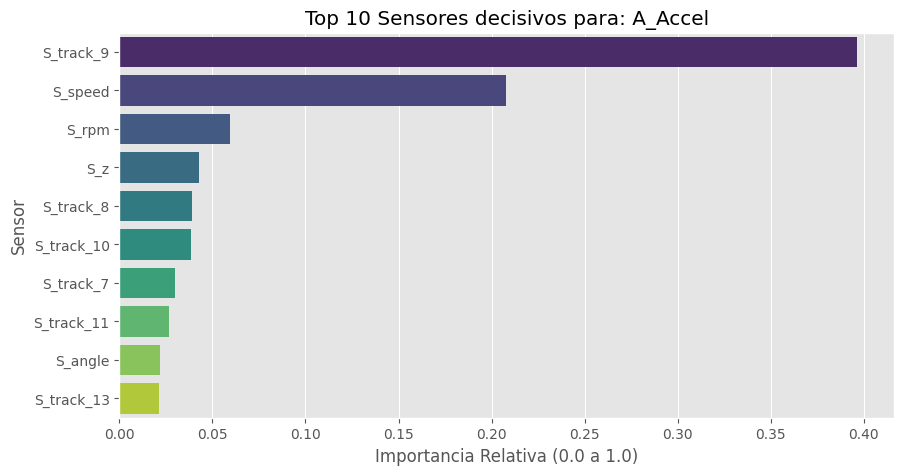

   >> El sensor rey para A_Accel es: S_track_9 (0.3966)



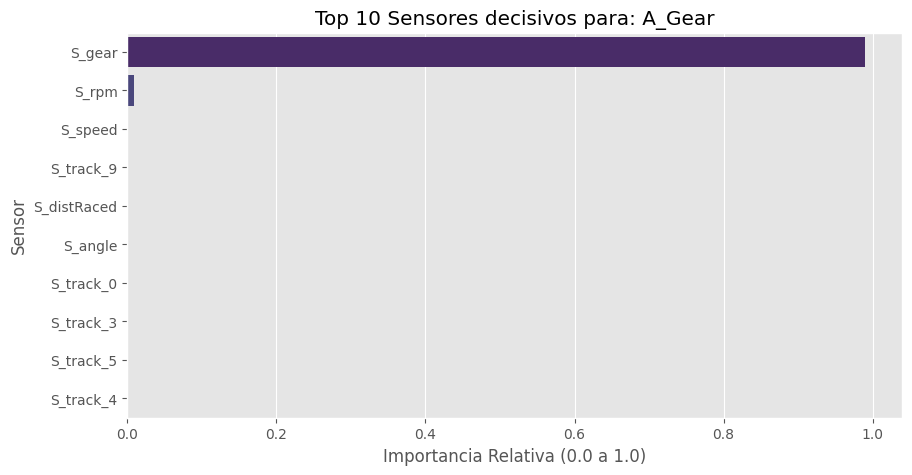

   >> El sensor rey para A_Gear es: S_gear (0.9905)



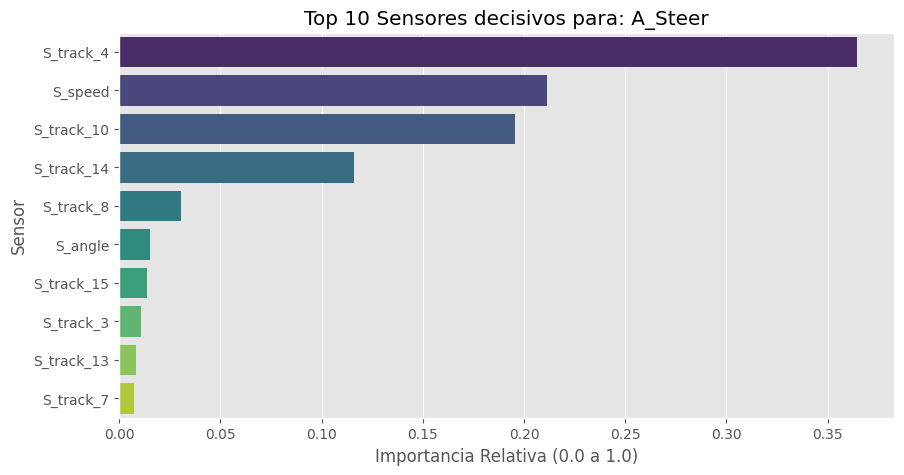

   >> El sensor rey para A_Steer es: S_track_4 (0.3647)



In [4]:
from sklearn.ensemble import RandomForestRegressor

print("ANÁLISIS DE IMPORTANCIA BASADO EN ARBOLES (Random Forest)")
print("Detecta relaciones complejas no lineales.")
print("-" * 60)

# Configuramos un modelo rápido
# n_jobs=-1 usa todos los núcleos de tu CPU para ir más rápido
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

# Iteramos sobre las columnas que existen realmente en 'y'
for col_accion in y.columns:
    
    # 1. Entrenar el modelo
    # Usamos X (datos limpios) y la columna de acción actual
    rf.fit(X, y[col_accion])
    
    # 2. Obtener la importancia de cada sensor
    importances = rf.feature_importances_
    
    # 3. Crear DataFrame temporal para ordenar
    # CORRECCIÓN IMPORTANTE: Usamos 'X.columns' en lugar de 'cols_sensores'
    # para que coincida con los sensores que sobrevivieron a la limpieza.
    temp_df = pd.DataFrame({
        'Sensor': X.columns,
        'Importancia': importances
    }).sort_values(by='Importancia', ascending=False).head(10)
    
    # 4. Graficar
    plt.figure(figsize=(10, 5))
    sns.barplot(data=temp_df, x='Importancia', y='Sensor', palette='viridis', hue='Sensor', legend=False)
    plt.title(f'Top 10 Sensores decisivos para: {col_accion}')
    plt.xlabel('Importancia Relativa (0.0 a 1.0)')
    plt.ylabel('Sensor')
    plt.show()
    
    # Opcional: Imprimir en texto también
    top_1 = temp_df.iloc[0]
    print(f"   >> El sensor rey para {col_accion} es: {top_1['Sensor']} ({top_1['Importancia']:.4f})\n")